<a href="https://colab.research.google.com/github/JyoAdd/HDS5210_InClass/blob/master/Final/Final_Project_Jyothsna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Environmental Data and Public Health Correlation **

 ## Data Access and Formats

In [107]:
# Importing the required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

=>***Loading the Data***

In [108]:
def load_csv(file_path):
    """
    Load a CSV file into a Pandas DataFrame.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_csv(file_path)

# Load health data
health_data = load_csv('Data_table_data.csv')

In [109]:
health_data.head()

,Iso3,Location Name,AMRO subregions,Causename Eng,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,Measure Values
0,AMRO,Region of the Americas,Region of the Americas,Asthma,2019,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666
1,AMRO,Region of the Americas,Region of the Americas,Asthma,2019,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193
2,AMRO,Region of the Americas,Region of the Americas,Asthma,2019,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703
3,AMRO,Region of the Americas,Region of the Americas,Asthma,2019,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313
4,AMRO,Region of the Americas,Region of the Americas,Asthma,2019,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372


In [110]:
def load_excel(file_path, sheet_name=0):
    """
    Load data from an Excel file.

    Parameters:
        file_path (str): Path to the Excel file.
        sheet_name (int/str): Sheet name or index to load.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_excel(file_path, sheet_name=sheet_name)

# Load IoT data
iot_data = load_excel('iot_telemetry_data.xlsx')


In [111]:
iot_data.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


## Data Transformation

=> ***Before merging Transformations for each dataset***

In [112]:
def transform_health_data(df):
    """
    Perform transformations on health data.

    Parameters:
        df (pd.DataFrame): Public health data.

    Returns:
        pd.DataFrame: Transformed public health data.
    """
    # 1. Drop missing values in the 'Measure Value' column
    df.dropna(subset=['Measure Values'], inplace=True)

    # 2. Rename column 'Date' to 'Day' and 'Measure Value' to 'HealthMetric'
    df.rename(columns={'Date': 'Day', 'Measure Values': 'HealthMetric'}, inplace=True)

    # 3. Convert 'Year' to a datetime object representing the start of the year
    df['Year'] = pd.to_datetime(df['Year'], format='%Y', errors='coerce')

    # 4. Ensure 'HealthMetric' is numeric
    df['HealthMetric'] = pd.to_numeric(df['HealthMetric'], errors='coerce')

    # 5. Categorize health risks based on 'HealthMetric'
    df['RiskCategory'] = pd.cut(
        df['HealthMetric'], bins=[0, 50, 100, 200], labels=['Low', 'Moderate', 'High']
    )

    # 6. Normalize text fields in 'RiskCategory' (convert to lowercase)
    df['RiskCategory'] = df['RiskCategory'].astype(str).str.lower()

    # 7. Add a derived column for metric deviation (difference from the mean)
    df['MetricDeviation'] = df['HealthMetric'] - df['HealthMetric'].mean()

    return df

In [113]:
health_data = transform_health_data(health_data)
print("Transformed Health Data:")
health_data.head()

Transformed Health Data:


,Iso3,Location Name,AMRO subregions,Causename Eng,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,HealthMetric,RiskCategory,MetricDeviation
0,AMRO,Region of the Americas,Region of the Americas,Asthma,2019-01-01,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666,low,-273.413898
1,AMRO,Region of the Americas,Region of the Americas,Asthma,2019-01-01,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193,low,-274.194371
2,AMRO,Region of the Americas,Region of the Americas,Asthma,2019-01-01,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703,low,-273.858861
3,AMRO,Region of the Americas,Region of the Americas,Asthma,2019-01-01,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313,nan,162.633748
4,AMRO,Region of the Americas,Region of the Americas,Asthma,2019-01-01,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372,high,-152.673193


In [114]:
def transform_iot_data(df):
    """
    Perform transformations on IoT telemetry data.

    Parameters:
        df (pd.DataFrame): IoT telemetry data.

    Returns:
        pd.DataFrame: Transformed IoT telemetry data.
    """
    # 1. Rename 'ts' to 'Timestamp' for consistency
    df.rename(columns={'ts': 'Timestamp'}, inplace=True)

    # 2. Convert Timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

    # 3. Convert Temperature to Celsius
    df['Temperature (°C)'] = (df['temp'] - 32) * 5 / 9

    # 4. Round Humidity
    df['humidity'] = df['humidity'].round(1)

    # 5. Ensure Air Quality Index is integer
    df['Air Quality Index'] = df['co'].astype(int)

    # 6. Add Alert for AQI > 150
    df['Alert'] = df['Air Quality Index'] > 150

    # 7. Categorize AQI
    conditions = [
        (df['Air Quality Index'] <= 50),
        (df['Air Quality Index'] > 50) & (df['Air Quality Index'] <= 100),
        (df['Air Quality Index'] > 100)
    ]
    categories = ['Good', 'Moderate', 'Poor']
    df['AQI Category'] = pd.cut(df['Air Quality Index'], bins=[0, 50, 100, 500], labels=categories, right=False)

    return df

In [115]:
# Transform IoT data
iot_data = transform_iot_data(iot_data)
print("Transformed IoT Data:")
iot_data.head()

Transformed IoT Data:


,Timestamp,device,co,humidity,light,lpg,motion,smoke,temp,Temperature (°C),Air Quality Index,Alert,AQI Category
0,1970-01-01 00:00:01.594512094,b8:27:eb:bf:9d:51,0.004956,51.0,False,0.007651,False,0.020411,22.700000,-5.166667,0,False,Good
1,1970-01-01 00:00:01.594512094,00:0f:00:70:91:0a,0.002840,76.0,False,0.005114,False,0.013275,19.700001,-6.833333,0,False,Good
2,1970-01-01 00:00:01.594512098,b8:27:eb:bf:9d:51,0.004976,50.9,False,0.007673,False,0.020475,22.600000,-5.222222,0,False,Good
3,1970-01-01 00:00:01.594512099,1c:bf:ce:15:ec:4d,0.004403,76.8,True,0.007023,False,0.018628,27.000000,-2.777778,0,False,Good
4,1970-01-01 00:00:01.594512101,b8:27:eb:bf:9d:51,0.004967,50.9,False,0.007664,False,0.020448,22.600000,-5.222222,0,False,Good


In [116]:
health_data['Year'] = pd.to_datetime(health_data['Year'], format='%Y').dt.year  # Ensure 'Year' is integer
iot_data['Year'] = pd.to_datetime(iot_data['Timestamp']).dt.year               # Extract year from 'Timestamp'

## Data Merging

In [117]:
def load_datasets(iot_path, health_path):
    """
    Load IoT and health datasets.

    Args:
        iot_path (str): Path to the IoT telemetry dataset (Excel file).
        health_path (str): Path to the health dataset (CSV file).

    Returns:
        tuple: Two pandas DataFrames containing IoT and health data respectively.
    """
    try:
        iot_data = pd.read_excel(iot_path)
        health_data = pd.read_csv(health_path)
        print("Datasets loaded successfully.")
        return iot_data, health_data
    except Exception as e:
        print(f"Error loading datasets: {e}")
        return None, None

In [118]:
def add_merge_id(data1, data2):
    """
    Add a 'merge_id' column to both datasets.

    Args:
        data1 (pandas.DataFrame): First dataset (IoT telemetry data).
        data2 (pandas.DataFrame): Second dataset (health data).

    Returns:
        tuple: Two pandas DataFrames with 'merge_id' columns added.
    """
    try:
        data1['merge_id'] = range(1, len(data1) + 1)
        data2['merge_id'] = range(1, len(data2) + 1)
        print("'merge_id' column added successfully.")
        return data1, data2
    except Exception as e:
        print(f"Error adding 'merge_id': {e}")
        return data1, data2

In [119]:
def merge_datasets(data1, data2, output_path):
    """
    Merge two datasets on 'merge_id' and save the result to a new CSV file.

    Args:
        data1 (pandas.DataFrame): First dataset with 'merge_id'.
        data2 (pandas.DataFrame): Second dataset with 'merge_id'.
        output_path (str): Path to save the merged dataset.

    Returns:
        pandas.DataFrame: The merged dataset.
    """
    try:
        merged_data = pd.merge(data1, data2, on='merge_id', how='outer')
        merged_data.to_csv(output_path, index=False)
        print(f"Merged dataset saved as '{output_path}'")
        return merged_data
    except Exception as e:
        print(f"Error merging datasets: {e}")
        return None

In [120]:
# Load and verify the merged dataset
print("Merged dataset saved as 'merged_iot_health_data.csv'")
merged_data_1 = pd.read_csv('merged_iot_health_data.csv')
merged_data_1.head()

Merged dataset saved as 'merged_iot_health_data.csv'


,ts,device,co,humidity,light,lpg,motion,smoke,temp,merge_id,...,Location Name,AMRO subregions,Causename Eng,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,Measure Values
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,1,...,Region of the Americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2,...,Region of the Americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,3,...,Region of the Americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,4,...,Region of the Americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,5,...,Region of the Americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372


In [121]:
# Test case 1: Load datasets
iot_data, health_data = load_datasets('iot_telemetry_data.xlsx', 'Data_table_data.csv')
assert iot_data is not None and not iot_data.empty, "Test failed: IoT dataset is empty."
assert health_data is not None and not health_data.empty, "Test failed: Health dataset is empty."

# Test case 2: Add 'merge_id' column
iot_data, health_data = add_merge_id(iot_data, health_data)
assert 'merge_id' in iot_data.columns, "Test failed: 'merge_id' column missing in IoT data."
assert 'merge_id' in health_data.columns, "Test failed: 'merge_id' column missing in health data."

# Test case 3: Merge datasets
merged_data = merge_datasets(iot_data, health_data, 'merged_iot_health_data.csv')
assert merged_data is not None and not merged_data.empty, "Test failed: Merged dataset is empty."

Datasets loaded successfully.
'merge_id' column added successfully.
Merged dataset saved as 'merged_iot_health_data.csv'


## Data Aggregations

In [122]:
#Aggregation 1 for the Merged data:
def aggregate_measure_by_location(data):
    """
    Aggregates the total measure values by location name.

    Args:
        data (DataFrame): The input dataset.

    Returns:
        DataFrame: Aggregated total measure values by location name.
    """
    return data.groupby('Location Name')['Measure Values'].sum().reset_index()

In [123]:
# Test code
data_path = 'merged_iot_health_data.csv'
data = pd.read_csv(data_path)
agg_location = aggregate_measure_by_location(data)
agg_location.head()

,Location Name,Measure Values
0,Andean Area,52958.671799
1,"Central America, Mexico and Latin Caribbean",60325.250412
2,Non-Latin Caribbean,55128.008359
3,North America,133226.779116
4,Region of the Americas,94192.182890


In [124]:
#Aggregation 2 for the Merged data:
def aggregate_avg_temp_by_year(data):
    """
    Aggregates the average temperature by year.

    Args:
        data (DataFrame): The input dataset.

    Returns:
        DataFrame: Average temperature grouped by year.
    """
    return data.groupby('Year')['temp'].mean().reset_index()

In [125]:
# Test code
agg_temp_year = aggregate_avg_temp_by_year(data)
agg_temp_year.head()

,Year,temp
0,2019.0,22.865486


## Data Pivoting

In [126]:
#Pivoting 1 for the Merged data:
def pivot_measure_by_location_year(data):
    """
    Creates a pivot table of measure values by location and year.

    Args:
        data (DataFrame): The input dataset.

    Returns:
        DataFrame: Pivot table of measure values by location and year.
    """
    return data.pivot_table(values='Measure Values', index='Location Name', columns='Year', aggfunc='sum')

In [127]:
# Test code
pivot_location_year = pivot_measure_by_location_year(data)
pivot_location_year.head()

Year,2019.0
Location Name,
Andean Area,52958.671799
"Central America, Mexico and Latin Caribbean",60325.250412
Non-Latin Caribbean,55128.008359
North America,133226.779116
Region of the Americas,94192.182890


In [128]:
#Pivoting 2 for the Merged data:
def pivot_avg_temp_by_location(data):
    """
    Creates a pivot table of average temperature by location.

    Args:
        data (DataFrame): The input dataset.

    Returns:
        DataFrame: Pivot table of average temperature by location.
    """
    return data.pivot_table(values='temp', index='Location Name', aggfunc='mean')

In [129]:
# Test code
pivot_temp_location = pivot_avg_temp_by_location(data)
pivot_temp_location.head()

,temp
Location Name,
Andean Area,22.762847
"Central America, Mexico and Latin Caribbean",22.891667
Non-Latin Caribbean,22.759722
North America,22.909722
Region of the Americas,23.003472


## Data Transformation

=> ***After merging data's***

In [130]:
#Transformation 1: Rename Columns
def rename_columns(df):
    """
    Rename specific columns for consistency.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with renamed columns.
    """
    df.rename(columns={
        'Air Quality Index': 'AQI',
        'Temperature (°C)': 'Temperature_C',
        'HealthMetric': 'Health_Metric',
        'Timestamp': 'Event_Time'
    }, inplace=True)
    return df

In [143]:
merged_data = rename_columns(merged_data)
print("After Renaming Columns:")
merged_data.head()

After Renaming Columns:


,ts,device,co,humidity,light,lpg,motion,smoke,temp,merge_id,...,Location Name,AMRO subregions,Causename Eng,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,Measure Values
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,1,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,3,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,4,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,5,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372


In [139]:
#Transformation 2: Normalize Text Fields
def normalize_text(df):
    """
    Normalize text fields to lowercase.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with normalized text fields.
    """
    df['Location Name'] = df['Location Name'].str.lower()
    return df

In [140]:
merged_data = normalize_text(merged_data)
print("After Normalizing Text Fields:")
merged_data.head()

After Normalizing Text Fields:


,ts,device,co,humidity,light,lpg,motion,smoke,temp,merge_id,...,Location Name,AMRO subregions,Causename Eng,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,Measure Values
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,1,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,3,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,4,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,5,...,region of the americas,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372


In [146]:
#Transformation 3: Derived Column for AQI-Temperature Difference
def add_aqi_temperature_difference(df):
    """
    Add a derived column calculating the difference between AQI and temperature.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with the derived column.
    """
    df['AQI_Temperature_Diff'] = df['co'] - df['temp']
    return df

In [147]:
merged_data = add_aqi_temperature_difference(merged_data)
print("After Adding AQI-Temperature Difference:")
merged_data.head()

After Adding AQI-Temperature Difference:


,ts,device,co,humidity,light,lpg,motion,smoke,temp,merge_id,...,AMRO subregions,Causename Eng,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,Measure Values,AQI_Temperature_Diff
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,1,...,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666,-22.695044
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2,...,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193,-19.697161
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,3,...,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703,-22.595024
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,4,...,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313,-26.995597
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,5,...,Region of the Americas,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372,-22.595033


In [150]:
#Transformation 4:Filter Valid Timestamps
def filter_valid_timestamps(df):
    """
    Filter out rows with invalid or missing timestamps.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Filtered DataFrame with valid timestamps.
    """
    df = df.dropna(subset=['ts'])  # Drop rows with missing timestamps
    df['Event_Time'] = pd.to_datetime(df['ts'], errors='coerce')  # Convert to datetime
    df = df.dropna(subset=['Event_Time'])  # Drop rows with invalid timestamps
    return df

In [151]:
merged_data = filter_valid_timestamps(merged_data)
print("After Filtering Valid Timestamps:")
merged_data.head()

After Filtering Valid Timestamps:


,ts,device,co,humidity,light,lpg,motion,smoke,temp,merge_id,...,Causename Eng,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,Measure Values,AQI_Temperature_Diff,Event_Time
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,1,...,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666,-22.695044,1970-01-01 00:00:01.594512094
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2,...,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193,-19.697161,1970-01-01 00:00:01.594512094
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,3,...,Asthma,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703,-22.595024,1970-01-01 00:00:01.594512098
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,4,...,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313,-26.995597,1970-01-01 00:00:01.594512099
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,5,...,Asthma,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372,-22.595033,1970-01-01 00:00:01.594512101


In [153]:
#Transformation 5:Categorize Temperature
def categorize_temperature(df):
    """
    Categorize temperatures into bins.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with categorized temperatures.
    """
    bins = [-10, 0, 15, 30, 50]
    labels = ['Very Cold', 'Cold', 'Moderate', 'Hot']
    df['Temperature_Category'] = pd.cut(df['temp'], bins=bins, labels=labels)
    return df

In [154]:
merged_data = categorize_temperature(merged_data)
print("After Categorizing Temperature:")
merged_data.head()

After Categorizing Temperature:


,ts,device,co,humidity,light,lpg,motion,smoke,temp,merge_id,...,Year,Sex,Age group,Measure Name En,Metric Name En,Measure Names,Measure Values,AQI_Temperature_Diff,Event_Time,Temperature_Category
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,1,...,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Up,1.468666,-22.695044,1970-01-01 00:00:01.594512094,Moderate
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,2,...,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value Low,0.688193,-19.697161,1970-01-01 00:00:01.594512094,Moderate
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,3,...,2019.0,Both sexes,Age-standardized,Deaths,Rate,Value,1.023703,-22.595024,1970-01-01 00:00:01.594512098,Moderate
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,4,...,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Up,437.516313,-26.995597,1970-01-01 00:00:01.594512099,Moderate
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,5,...,2019.0,Both sexes,Age-standardized,Disability-Adjusted Life Years (DALYs),Rate,Value Low,122.209372,-22.595033,1970-01-01 00:00:01.594512101,Moderate


## Data Visualizations

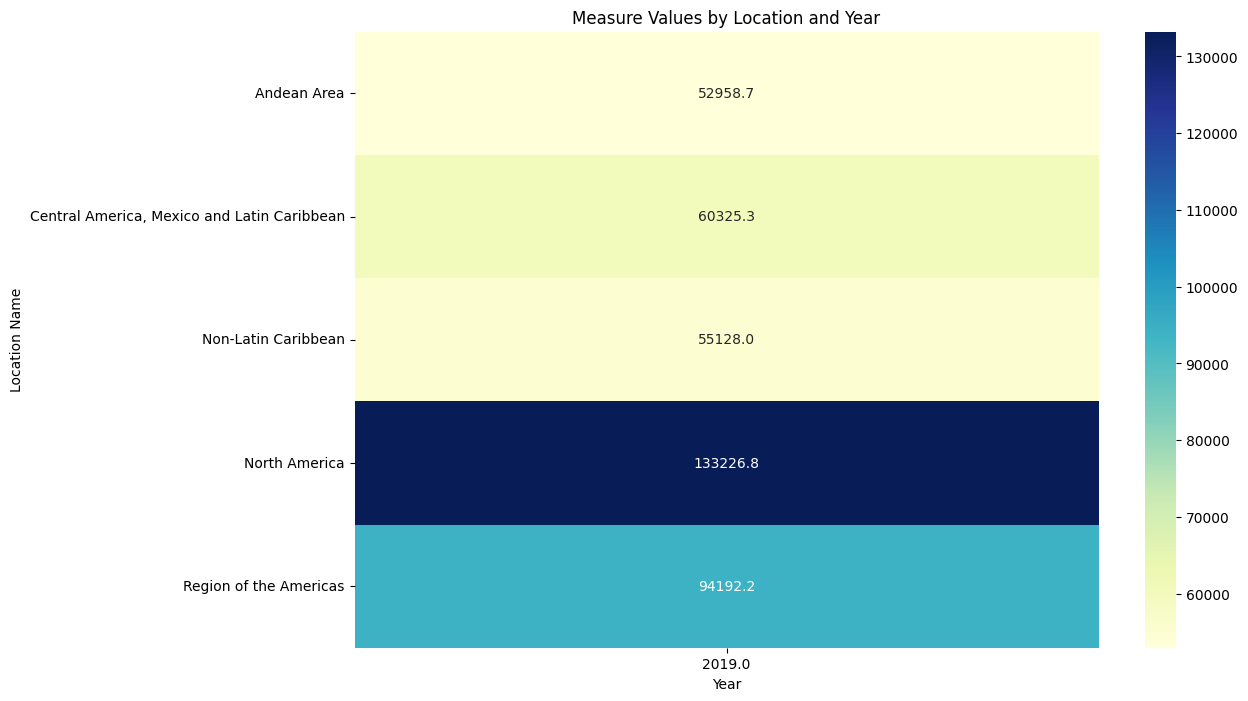

In [155]:
# Visualization 1: HEATMAP
def plot_heatmap_measure_location_year(data):
    """
    Plots a heatmap of measure values by location and year.

    Args:
        data (DataFrame): Pivot table of measure values by location and year.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(data, cmap='YlGnBu', annot=True, fmt=".1f")
    plt.title('Measure Values by Location and Year')
    plt.xlabel('Year')
    plt.ylabel('Location Name')
    plt.show()
# Test code
plot_heatmap_measure_location_year(pivot_location_year)

-> *Heatmap of Measure Values by Location and Year* :
The heatmap visualizes how measure values vary by location and year, providing insights into spatial and temporal health trends across different regions.

---



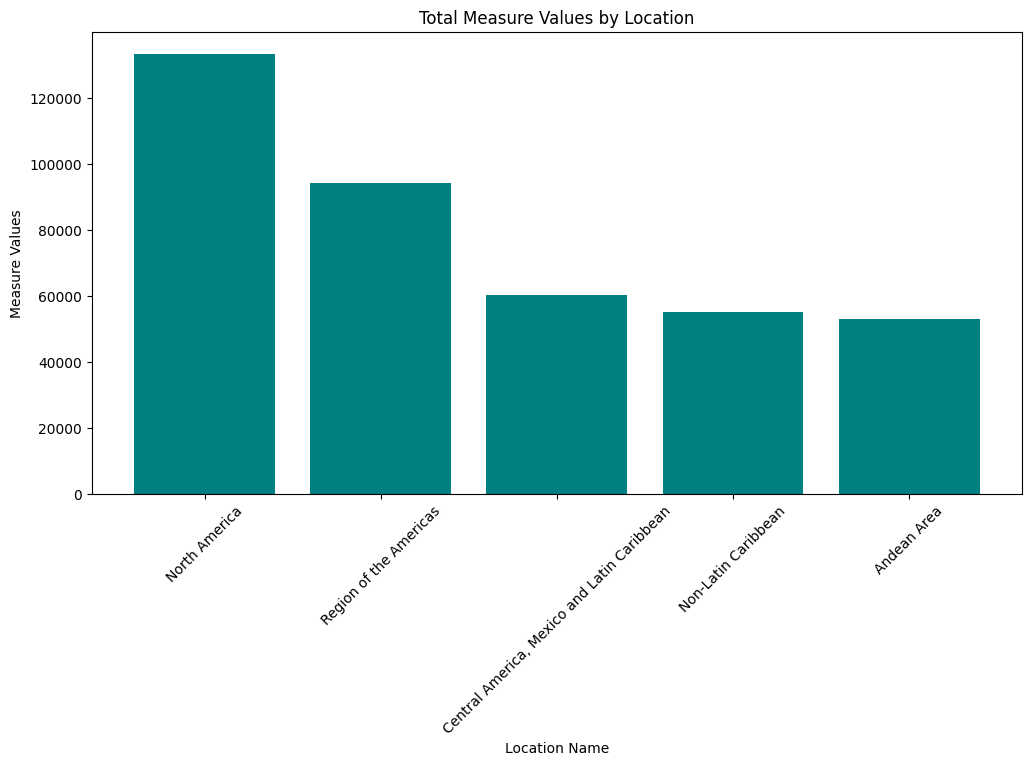

In [156]:
# Visualization 2: BARCHART
def plot_measure_by_location(data):
    """
    Plots a bar chart of total measure values by location.

    Args:
        data (DataFrame): Aggregated dataset with 'Location Name' and 'Measure Values' columns.
    """
    data.sort_values('Measure Values', ascending=False, inplace=True)
    plt.figure(figsize=(12, 6))
    plt.bar(data['Location Name'], data['Measure Values'], color='teal')
    plt.title('Total Measure Values by Location')
    plt.xlabel('Location Name')
    plt.ylabel('Measure Values')
    plt.xticks(rotation=45)
    plt.show()
# Test code
plot_measure_by_location(agg_location)

-> *Bar Chart of Total Measure Values by Disease* :
This bar chart displays the total measure values for different diseases, allowing quick comparisons to assess the health impact of various conditions.

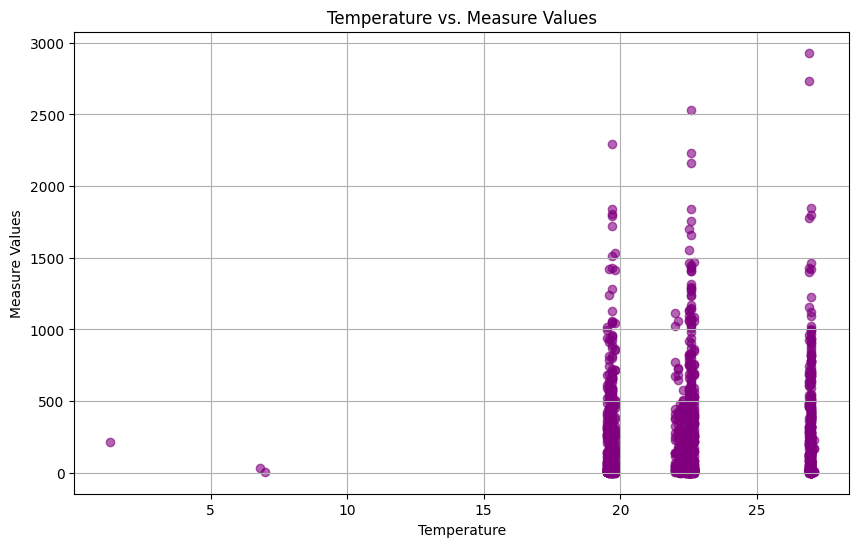

In [157]:
# Visualization 3: SCATTERPLOT
def plot_temp_vs_measure(data):
    """
    Plots a scatter plot of temperature vs. measure values.

    Args:
        data (DataFrame): The input dataset with 'temp' and 'Measure Values' columns.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(data['temp'], data['Measure Values'], alpha=0.6, color='purple')
    plt.title('Temperature vs. Measure Values')
    plt.xlabel('Temperature')
    plt.ylabel('Measure Values')
    plt.grid()
    plt.show()
# Test code
plot_temp_vs_measure(data)

-> *Scatter Plot of Temperature vs. Measure Values* :
The scatter plot shows the relationship between temperature and measure values, highlighting potential correlations between environmental factors and health outcomes.

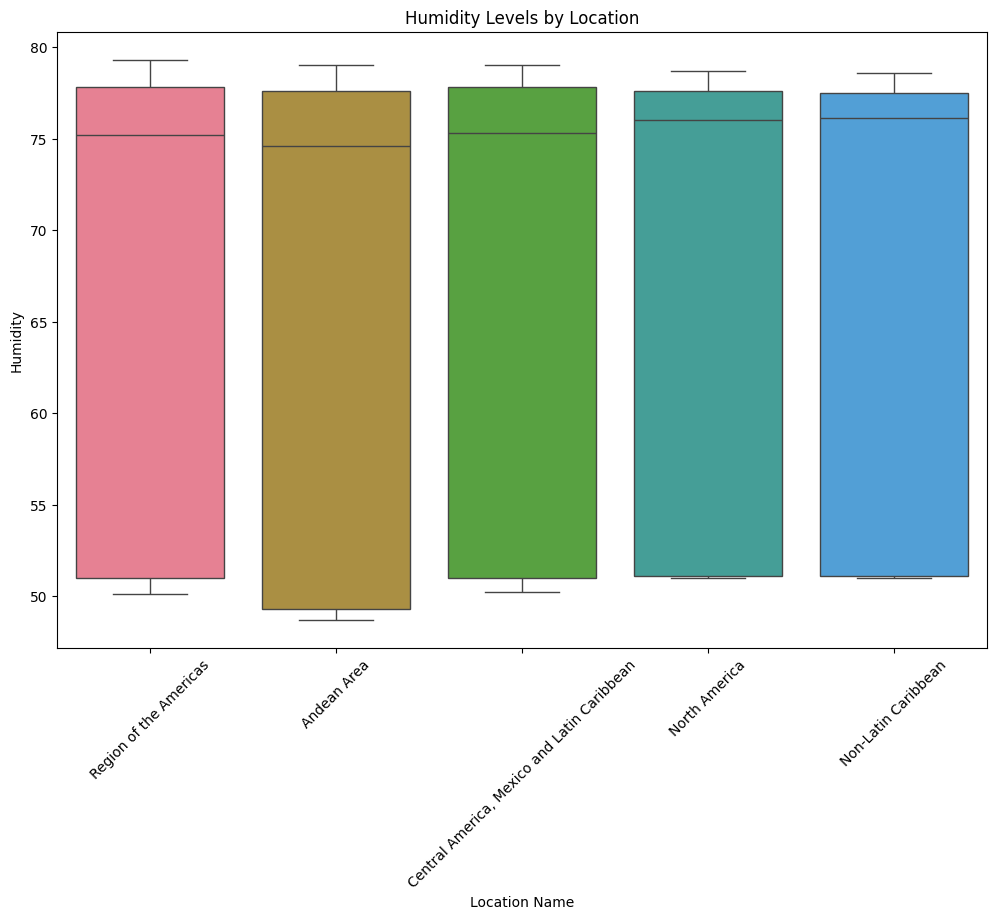

In [158]:
# Visualization 4: BOXPLOT
def plot_box_humidity_by_location(data):
    """
    Plots a box plot of humidity levels by location with unique colors for each box.

    Args:
        data (DataFrame): The input dataset with 'Location Name' and 'humidity' columns.
    """
    plt.figure(figsize=(12, 8))
    unique_locations = data['Location Name'].unique()
    palette = sns.color_palette("husl", len(unique_locations))
    sns.boxplot(x='Location Name', y='humidity', data=data, palette=palette)
    plt.title('Humidity Levels by Location')
    plt.xlabel('Location Name')
    plt.ylabel('Humidity')
    plt.xticks(rotation=45)
    plt.show()
# Test code
plot_box_humidity_by_location(data)

->* Box Plot of Humidity Levels by Location* :
The box plot illustrates the distribution of humidity levels across various locations, helping identify outliers and variations in environmental conditions.

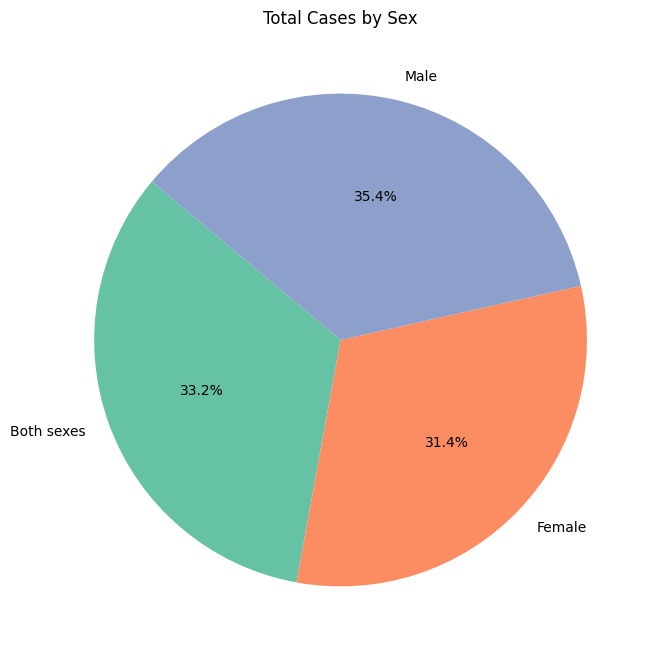

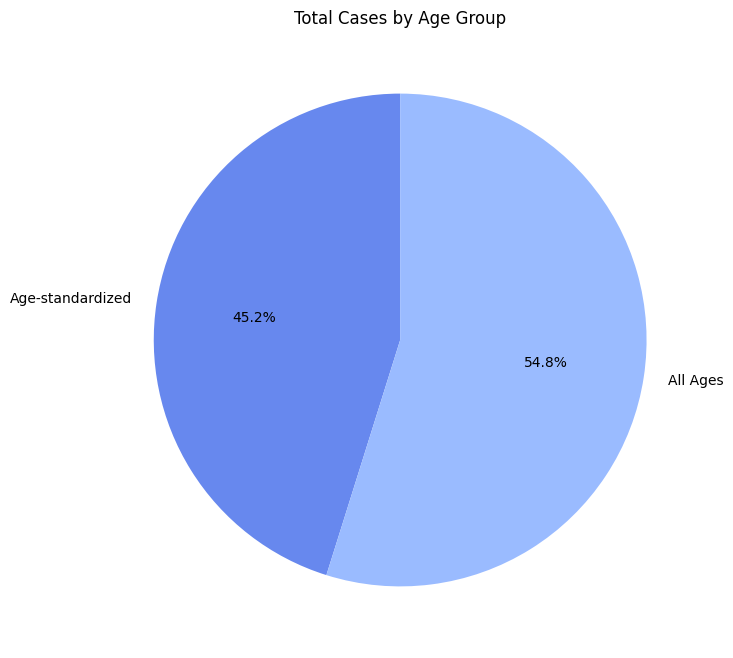

In [159]:
# Visualization 6: PIECHART
def plot_pie_cases_by_sex(data):
    """
    Plots a pie chart showing the distribution of total cases by sex.

    Args:
        data (DataFrame): The input dataset with 'Sex' and 'Measure Values' columns.
    """
    cases_by_sex = data.groupby('Sex')['Measure Values'].sum()
    plt.figure(figsize=(8, 8))
    plt.pie(cases_by_sex, labels=cases_by_sex.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
    plt.title('Total Cases by Sex')
    plt.show()
# Test code
plot_pie_cases_by_sex(data)

def plot_pie_cases_by_age_group(data):
    """
    Plots a pie chart showing the distribution of total cases by age group.

    Args:
        data (DataFrame): The input dataset with 'Age group' and 'Measure Values' columns.
    """
    cases_by_age = data.groupby('Age group')['Measure Values'].sum()
    plt.figure(figsize=(8, 8))
    plt.pie(cases_by_age, labels=cases_by_age.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("coolwarm"))
    plt.title('Total Cases by Age Group')
    plt.show()
# Test code
plot_pie_cases_by_age_group(data)

->*Pie Chart of Total Cases by Sex* :
This pie chart displays the distribution of total cases by sex, helping to visualize how health conditions are spread across different genders.

->*Pie Chart of Total Cases by Age Group* :
This pie chart shows how total health cases are distributed across different age groups, highlighting the age demographics most affected by environmental health issues.

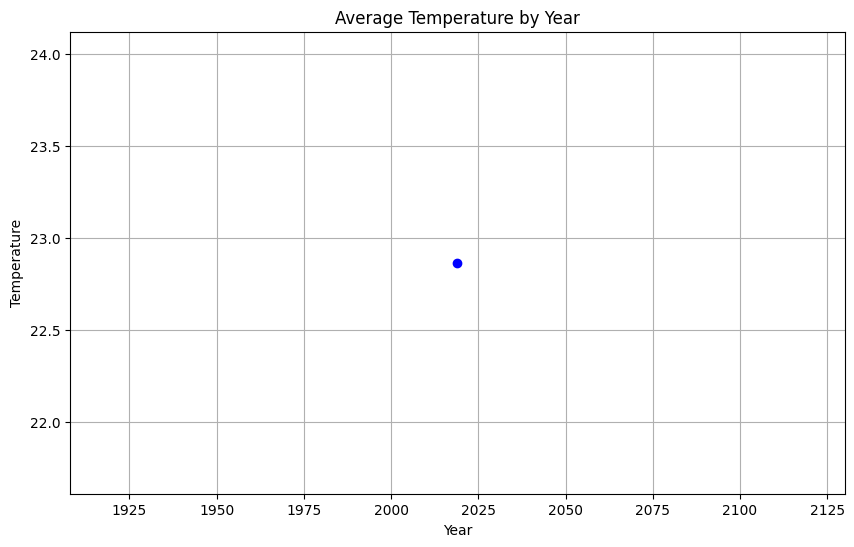

In [160]:
# Visualization 7: LINEPLOT
import matplotlib.pyplot as plt

def plot_avg_temp_by_year(data):
    """
    Plots the average temperature by year.

    Args:
        data (DataFrame): Aggregated dataset with 'Year' and 'temp' columns.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(data['Year'], data['temp'], marker='o', linestyle='-', color='blue')
    plt.title('Average Temperature by Year')
    plt.xlabel('Year')
    plt.ylabel('Temperature')
    plt.grid()
    plt.show()
# Test code
plot_avg_temp_by_year(agg_temp_year)


->*Line Plot of Average Temperature by Year* :This line plot shows how the average temperature fluctuates over time, helping to track seasonal trends and long-term temperature changes that may impact public health.

### Conclusion

The **Environmental Data and Public Health Correlation** highlights the critical relationship between environmental factors and public health outcomes, particularly focusing on respiratory and cardiovascular diseases. By combining data on air quality, temperature, and humidity with public health metrics, this provides valuable insights that could serve as an early warning system for healthcare providers. Public health agencies can use this tool to identify high-risk areas, allocate resources effectively, and develop targeted interventions, such as health campaigns or deploying mobile clinics in regions affected by poor environmental conditions.

Beyond healthcare, this has broader applications in policymaking, urban planning, and environmental management. Policymakers can use the insights to justify stricter environmental regulations, while city planners and industries can leverage the data to design healthier living spaces and mitigate pollution risks. Although theoretical, this demonstrates the power of integrating diverse datasets to address real-world challenges and has the potential to improve community health and influence cross-industry decision-making.